In [114]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

KEY_COLS = ['lat', 'lon', 'time', 'gb_year', 'gb_month']
VALUE_COLS = ['lst_night', 'lst_day', 'precip', 'sm', 'spi', 'spei', 'ndvi', 'evi']
VEGETATION_LABELS = ['ndvi', 'evi']
TARGET_COL = 'ndvi'

In [9]:
BASE_DIR = Path("../")
RAW_DATA_DIR = Path("../data/raw")

# change this to your data path
EXT_DATA_DIR = Path("/Volumes/Lees_Extend/data/ea_data")

In [18]:
ds = xr.open_dataset(EXT_DATA_DIR/"OUT.nc")
ds

<xarray.Dataset>
Dimensions:                 (lat: 404, lon: 316, time: 85)
Coordinates:
  * time                    (time) datetime64[ns] 2010-01-01 ... 2017-01-01
  * lon                     (lon) float32 32.524994 32.574997 ... 48.274994
  * lat                     (lat) float32 -4.9750023 -4.925003 ... 15.174995
    month                   (time) int64 ...
Data variables:
    lst_day                 (time, lat, lon) float64 ...
    lst_night               (time, lat, lon) float64 ...
    lst_mean                (time, lat, lon) float64 ...
    evaporation             (time, lat, lon) float64 ...
    baresoil_evaporation    (time, lat, lon) float64 ...
    potential_evaporation   (time, lat, lon) float64 ...
    transpiration           (time, lat, lon) float64 ...
    surface_soil_moisture   (time, lat, lon) float64 ...
    rootzone_soil_moisture  (time, lat, lon) float64 ...
    sm                      (time, lat, lon) float64 ...
    precip                  (time, lat, lon) float6

In [128]:
def compute_anomaly(da, time_group='time.month'):
    """ Return a dataarray where values are an anomaly from the MEAN for that
         location at a given timestep. Defaults to finding monthly anomalies.

    Arguments:
    ---------
    : da (xr.DataArray)
    : time_group (str)
        time string to group.
    """
    mthly_vals = da.groupby(time_group).mean('time')
    da = da.groupby(time_group) - mthly_vals

    return da


def update_year_month(times, pred_month):
    """Given a pred year (e.g. 6), this method will return two new series with
    updated years and months so that a "year" of data will be the 11 months preceding the
    pred_month, and the pred_month. This makes it easier for the engineer to then make the training
    data
    """
    if pred_month == 12:
        return times.dt.month, times.dt.year

    relative_times = times - pd.DateOffset(months=pred_month)

    # we add one year so that the year column the engineer makes will be reflective
    # of the pred year, which is shifted because of the data offset we used
    return relative_times.dt.month, relative_times.dt.year + 1


In [160]:
da = ds.ndvi
mthly_vals = da.groupby('time.month').mean('time')
anom = da.groupby('time.month') - mthly_vals
anom2 = da - mthly_vals

/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Let's just check that this is doing something sensible. The final `anom2` plot is just a check that the extra groupby is necessary.

It turns out it is required otherwise we add an extra dimension to our object

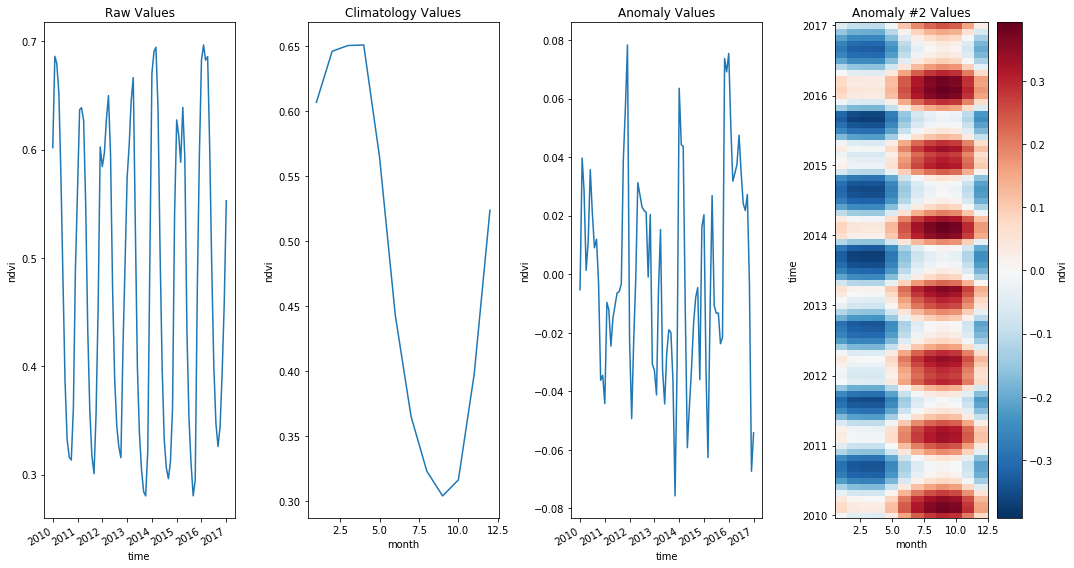

In [161]:
lat=0
lon=0

fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize=(15,8))
da.isel(lat=lat, lon=lon).plot(ax=ax1)
ax1.set_title('Raw Values')
mthly_vals.isel(lat=lat, lon=lon).plot(ax=ax2)
ax2.set_title('Climatology Values')
anom.isel(lat=lat, lon=lon).plot(ax=ax3)
ax3.set_title('Anomaly Values')
anom2.isel(lat=lat, lon=lon).plot(ax=ax4)
ax4.set_title('Anomaly #2 Values')

plt.tight_layout()